In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from matplotlib import pyplot
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import pathlib
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dropout, GRU, Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
x_voc = 8440
y_voc = 1989

In [11]:
# load the weights
w_encoder_embeddings = np.load('model/enc_embedding.npz', allow_pickle=True)
w_decoder_embeddings = np.load('model/dec_embedding.npz', allow_pickle=True)
w_encoder_lstm0 = np.load('model/encoder_lstm0.npz', allow_pickle=True)
w_encoder_lstm1 = np.load('model/encoder_lstm1.npz', allow_pickle=True)
w_decoder_lstm = np.load('model/lstm_2.npz', allow_pickle=True)
time_distributed  = np.load('model/time_distributed.npz', allow_pickle=True)

In [24]:
# Bidirectional LSTM
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(None,))

# embedding layer
enc_emb =  Embedding(63320, 100, trainable=True, name = "enc_embedding")(encoder_inputs)


encoder_lstm0 = Bidirectional(
    LSTM(latent_dim, return_sequences=True),
    name = 'encoder_lstm0')
encoder_outputs0 = encoder_lstm0(enc_emb)

encoder_lstm1 = Bidirectional(
    LSTM(latent_dim, return_state=True),
    name = 'encoder_lstm1')
encoder_outputs, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c  = encoder_lstm1(encoder_outputs0)


state_h = Concatenate()([enc_forward_h, enc_backward_h])
state_c = Concatenate()([enc_forward_c, enc_backward_c])
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(14856, 100,trainable=True, name = 'dec_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0)
decoder_outputs1, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([decoder_outputs1, encoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs1, attn_out])

#dense layer
decoder_dense = TimeDistributed(Dense(14856, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_embedding (Embedding)       (None, None, 100)    6332000     input_1[0][0]                    
__________________________________________________________________________________________________
encoder_lstm0 (Bidirectional)   (None, None, 600)    962400      enc_embedding[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [25]:
# set the weights of the model

model.layers[1].set_weights(w_encoder_embeddings['arr_0'])
model.layers[2].set_weights(w_encoder_lstm0['arr_0'])
model.layers[4].set_weights(w_encoder_lstm1['arr_0'])
model.layers[5].set_weights(w_decoder_embeddings['arr_0'])
model.layers[8].set_weights(w_decoder_lstm['arr_0'])
model.layers[11].set_weights(time_distributed['arr_0'])

In [46]:
import pickle
# load the tokenizer
with open('model/x_tokenizer.pickle', 'rb') as handle:
    x_tokenizer = pickle.load(handle)
with open('model/y_tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [28]:
#bidirectional
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

https://stackoverflow.com/questions/70128813/how-do-i-save-an-encoder-decoder-model-with-tensorflow

In [29]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 

def top_k_sampling(predictions, k):
    top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
#     print(reverse_target_word_index[sampled_token])
#     top_k_tokens=[dictionary[i] for i in top_k_indices]
#     plt.bar(top_k_tokens,top_k_redistributed_probability)
#     plt.show()
    return sampled_token

In [30]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        #sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_index = top_k_sampling(output_tokens[0, -1, :],5)
        #sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :])
  
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [32]:
data=pd.read_csv(f"{pathlib.Path().resolve()}\\input\\cnn_dailymail\\train.csv", nrows=10000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          10000 non-null  object
 1   article     10000 non-null  object
 2   highlights  10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [33]:
data.drop_duplicates(subset=['article'],inplace=True) #dropping duplicates
data.dropna(axis=0,inplace=True) #dropping na

In [34]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [35]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString).text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if (num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: # removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [36]:
#call the function
cleaned_text = []
for t in data['article']:
    cleaned_text.append(text_cleaner(t,0)) 

In [37]:
#call the function
cleaned_summary = []
for t in data['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

In [38]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [39]:
#drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Mean of Article Length 374.88456536961087
Mean of Summary Length 46.14494348304491


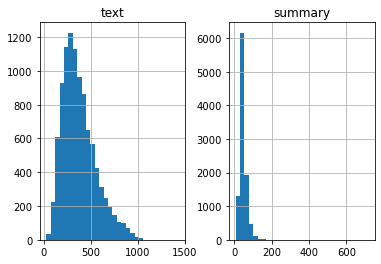

In [40]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
print('Mean of Article Length',sum(text_word_count)/len(text_word_count))
print('Mean of Summary Length',sum(summary_word_count)/len(summary_word_count))
length_df.hist(bins = 30)
plt.show()

In [41]:
max_text_len=400
max_summary_len=46

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [42]:
#making sure tokens dont appear in the summaries
for summary in df['summary']:
    if 'sostok' in summary:
        print("ERROR")
    if 'eostok' in summary:
        print("ERROR")

In [43]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [44]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [63]:
#bidirectional
for i in range(0,10):
    x_val_seq   =   x_tokenizer.texts_to_sequences([x_val[i]])
    x_val_i   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
    
    y_val_seq   =   y_tokenizer.texts_to_sequences([y_val[i]])
    y_val_i   =   pad_sequences(y_val_seq, maxlen=max_text_len, padding='post')

    print("Article:",seq2text(x_val_i[0]))
    print("Original summary:",seq2summary(y_val_i[0]))
    print("Predicted summary:",decode_sequence(x_val_i[0].reshape(1,max_text_len)))
    print("\n")

Article: lytro cameras let take photo refocus anywhere taken getting two much requested new features instagram like filters ability bring entire image one section focus camera released early year new silicon valley based startup long rectangular small touchscreen one end minimal buttons camera uses light field technology capture interactive images since camera release lytro employees busy testing releasing new features recent additions available december first new perspective shift feature could focus one small section lytro image time seemed negate benefit camera could focus everything frame perspective shift finally allows bring entire image focus interesting part click drag lytro picture also effect allowing move image around altered angles existing lytro camera owners happy learn effect applied older images well one test photo eric cheng lytro director photography former underwater photographer filled glass christmas ornament paint shot pellet capturing explosion happened desktop a

Predicted summary:  new the prime minister says it will be on the way to discuss new president the former president says his body will not be the first time in the united states


Article: withering lord rennard questioned whether nick clegg still leading major party following latest election humiliation lord rennard questioned whether nick clegg still leading major party following latest election humiliation former chief executive liberal democrats said party rock bottom showing last week rochester poll came fifth less per cent vote unacceptable warned latest failure makes chances lib dems holding dozens seats next general election much harder lord rennard barbed accusation lib dems minor party seen revenge mr clegg allowing back heart party lib dem peer party chief executive suspended early year series women accused making sexual advances denied allegations issued apology encroaching women personal space august suspension controversially lifted although told would role next year elec

Predicted summary:  protesters on the streets of the vote will not be first on its first time in january the president has been in the run of the new parliament


Article: police force making cuts million using unqualified detectives investigate serious crimes critical shortage staff whistleblower said officers moved criminal investigation department brighton west sussex deals murders rapes without taking compulsory detective exams sussex police admitted officers moved brighton cid temporarily keep numbers prompting warning county police commissioner shortage police brighton admitted facing called challenging times whistleblower reported concerns local newspaper brighton argus critical shortage police officers across entire brighton hove division anonymous detective said added officers drafted departments almost notice many officers even passed detectives exam national requirement little additional training prepare dealing serious crimes investigated cid uncommon see colleagues verge t